# **Familiarization with RDKit in Python: tutorial part**

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import RDLogger
from rdkit import Chem, DataStructs
from rdkit.Chem import (
PandasTools,
Draw,
Descriptors,
MACCSkeys,
rdFingerprintGenerator,
AllChem,
)

In [2]:
molecule_smiles = [
"CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
"CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
"C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
"CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
"C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl"]

In [3]:
molecule_names = [
"4-(dimethylamino)-1,5,10,11,12a-pentahydroxy-6-methyl-3,12-dioxo-4a,5,5a,6-tetrahydro-4H-tetracene-2-carboxamide",
"6-[[2-amino-2-(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid",
"4-chloro-2-(furan-2-ylmethylamino)-5-sulfamoylbenzoic acid",
"2-dodecanoyloxyethyl dodecanoate",
"6-chloro-1,1-dioxo-3,4-dihydro-2H-1lambda6,2,4-benzothiadiazine-7-sulfonamide"]

The ROMol object is the one used to calculate all proper4es by the RDKit librairies

In [4]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
# Show first 2 molecules
molecules.head(2)

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,"4-(dimethylamino)-1,5,10,11,12a-pentahydroxy-6...",<rdkit.Chem.rdchem.Mol object at 0x0000017E708...
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,6-[[2-amino-2-(4-hydroxyphenyl)acetyl]amino]-3...,<rdkit.Chem.rdchem.Mol object at 0x0000017E708...


Picture all molecules in image format with the following 

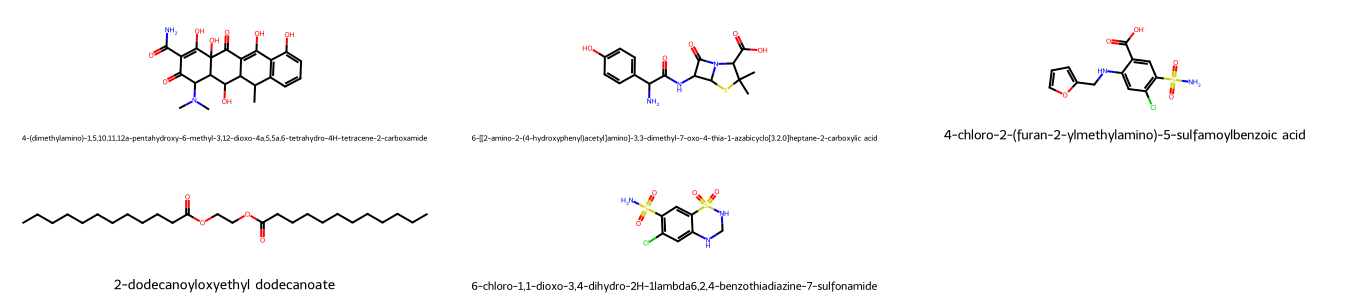

In [5]:
Draw.MolsToGridImage(
molecules["ROMol"].to_list(),
molsPerRow=3,
subImgSize=(450, 150),
legends=molecules["name"].to_list())

Molecular weight can be calculated like this:

In [6]:
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)
# Sort molecules by molecular weight
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)

Rank each descriptors as liked and picture it:

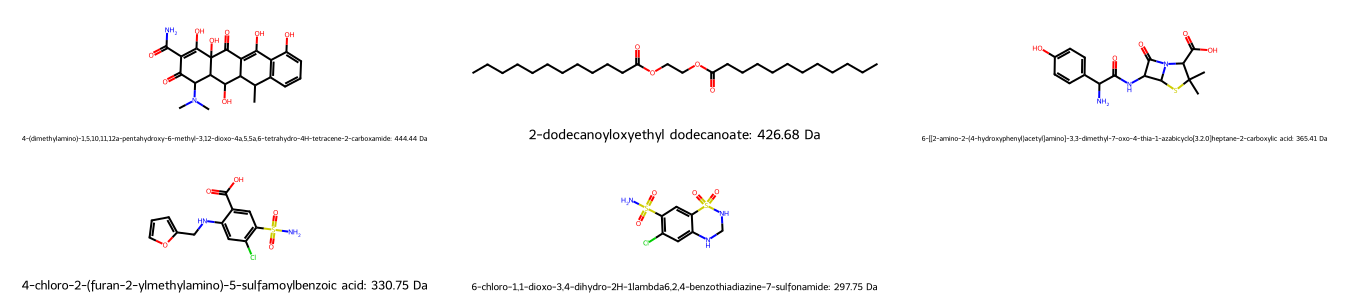

In [7]:
Draw.MolsToGridImage(
molecules["ROMol"],
legends=[
f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da"
for index, molecule in molecules.iterrows()
],
subImgSize=(450, 150),
molsPerRow=3,
)

## MACCS and Morgan Fingerprints

Two different variants: 960 or 166 bits keys, based on fragment identification by
SMARTS (SMILES arbitrary target specification) or based on
SMARTS system (developed by Daylight) allows to search directly subs-structure
within SMILES molecules.
SMARTS (SMILES arbitrary target specification) and each bit indicates the presence or absence of a specific chemical substructure.

Morgan fingerprints (ECFP) are generated by computing hashed identifiers of atom-centered local environments, obtained by iteratively expanding from each atom to its neighboring atoms up to a specified radius.
These environments are then hashed and mapped into a fixed-length binary vector.

We can calculate the fingerprints associated to our compounds

In [8]:
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)
molecules ["morgan" ]=molecules["ROMol"].apply(lambda mol:AllChem.GetMorganFingerprintAsBitVect
(mol, 2, nBits=2048, useChirality=False) )

[09:51:38] DEPRECATION WARNING: please use MorganGenerator
[09:51:38] DEPRECATION WARNING: please use MorganGenerator
[09:51:38] DEPRECATION WARNING: please use MorganGenerator
[09:51:38] DEPRECATION WARNING: please use MorganGenerator
[09:51:38] DEPRECATION WARNING: please use MorganGenerator


Now, two new columns have appeared in the data frame, the fingerprints one, encoded by
vectors of 2048 bits as 1 and 0 values.

### Molecular similarity by Tanimoto and Dice coefficient with MACCS fingerprint:

In [9]:
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

### Dice and Tanimoto difference
Tanimoto coefficient allows the comparison of two molecules, based on their
fingerprints 𝑆ab = 𝐶 / (𝐴 + 𝐵 − 𝐶)
A and B are the bit number of the considered fingerprint equal to 1, respectively in the
two considered molecules and C the bits equal to 1 in BOTH fingerprints.
SAB is the similarity rate between two molecules, between 0 and 1. At 1, molecules are
identical.

Dice is similar to Tanimoto, but the intersection is counte twice. By consequence, it is more sensible than Tanimoto on
similarity.

Sort the dataframe by similarity 

In [10]:
preview = molecules.sort_values(["tanimoto_maccs"],
ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_maccs,dice_maccs
0,"4-(dimethylamino)-1,5,10,11,12a-pentahydroxy-6...",1.000000,1.000000
1,6-[[2-amino-2-(4-hydroxyphenyl)acetyl]amino]-3...,0.590909,0.742857
2,4-chloro-2-(furan-2-ylmethylamino)-5-sulfamoyl...,0.321839,0.486957
3,"6-chloro-1,1-dioxo-3,4-dihydro-2H-1lambda6,2,4...",0.306818,0.469565
4,2-dodecanoyloxyethyl dodecanoate,0.149254,0.259740


Represent all molecules with the values of the calculated coefficient

In [11]:
def draw_ranked_molecules(molecules, sort_by_column):
    molecules_sorted = molecules.sort_values([sort_by_column],ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
        f"#{index+1} {molecule['name']}, similarity={molecule[sort_by_column]:.2f}"
        for index, molecule in molecules_sorted.iterrows()
    ],
    molsPerRow=3,
    subImgSize=(450, 150),
    )

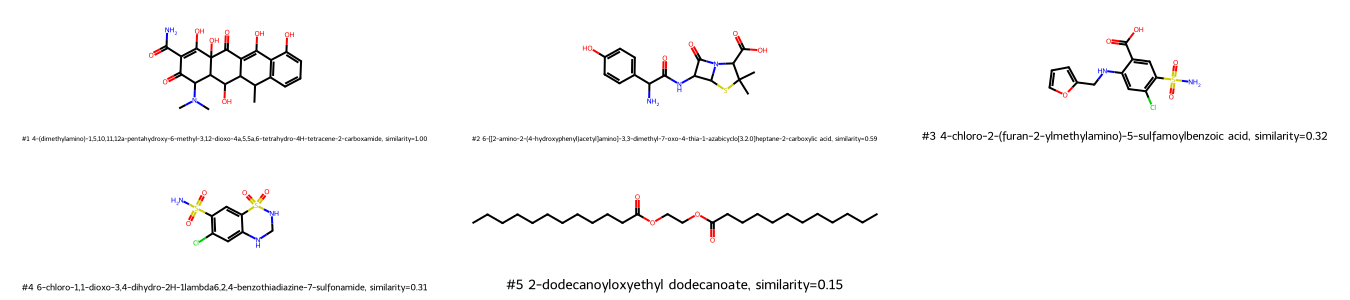

In [12]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

### Dice and Tanimoto based on the Morgan fingerprints

In [13]:
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query,
molecule_list)

In [14]:
molecules.to_csv('C:/Users/Sossey/Documents/chemoinformatic/data/mol.csv')

# **Applying this protocol on a concrete case: virtual screening with similarity**

**Dataset of molecules targeting the EGFR protein kinase**

In [15]:
molecule_dataset = pd.read_csv('C:/Users/Sossey/Documents/chemoinformatic/data/Compounds_TP4.csv',
usecols=["molecule_chembl_id", "SMILES", "pIC50"], delimiter= ";")

In [16]:
molecule_dataset.shape

(6213, 3)

In [17]:
molecule_dataset.head()

,molecule_chembl_id,SMILES,pIC50
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.017729
1,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,3.045757
2,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,5.484537
3,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,5.136677
4,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1,6.494850


Starting with the reference molecule called Gefitinib, a historical inhibitor of the EGFR
protein (The chembl id is CHEMBL939)

In [18]:
molecule_dataset[molecule_dataset['molecule_chembl_id']=='CHEMBL939']

,molecule_chembl_id,SMILES,pIC50
6191,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,6.288193


**Creation of the ROMol object**

In [19]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, smilesCol="SMILES")
# Show first 2 molecules
molecule_dataset.head(2)

,molecule_chembl_id,SMILES,pIC50,ROMol
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.017729,<rdkit.Chem.rdchem.Mol object at 0x0000017E71D...
1,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,3.045757,<rdkit.Chem.rdchem.Mol object at 0x0000017E71D...


### MACCS and Morgan Fingerprints


In [20]:
molecule_dataset["maccs"] = molecule_dataset.ROMol.apply(MACCSkeys.GenMACCSKeys)
molecule_dataset["morgan"] = molecule_dataset["ROMol"].apply(lambda mol:AllChem.GetMorganFingerprintAsBitVect
                                                              (mol, 2, nBits=2048,useChirality=False))

[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerator
[09:51:57] DEPRECATION WARNING: please use MorganGenerat

### Molecular similarity by Tanimoto and Dice coefficient with MACCS fingerprint:

In [21]:
molecule_query = molecule_dataset["maccs"][6191]
molecule_list = molecule_dataset["maccs"].to_list()
# Calculate similarty values between query and list elements
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [22]:
preview = molecules.sort_values(["tanimoto_maccs"],
ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_maccs,dice_maccs
0,"4-(dimethylamino)-1,5,10,11,12a-pentahydroxy-6...",1.000000,1.000000
1,6-[[2-amino-2-(4-hydroxyphenyl)acetyl]amino]-3...,0.590909,0.742857
2,4-chloro-2-(furan-2-ylmethylamino)-5-sulfamoyl...,0.321839,0.486957
3,"6-chloro-1,1-dioxo-3,4-dihydro-2H-1lambda6,2,4...",0.306818,0.469565
4,2-dodecanoyloxyethyl dodecanoate,0.149254,0.259740


**MACCS similarity results using visual representation**

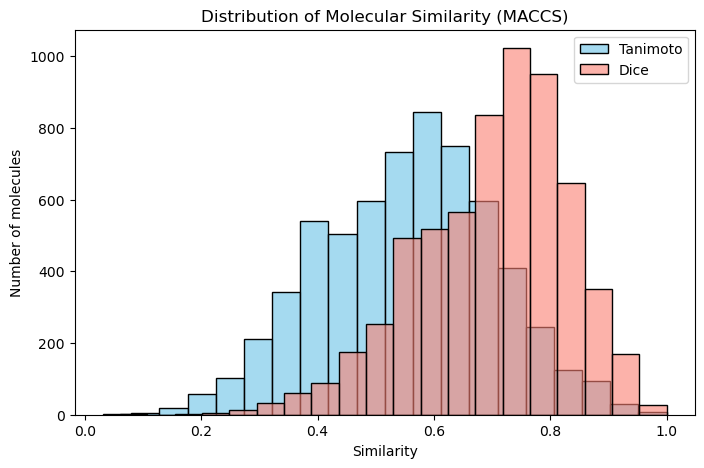

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(molecule_dataset["tanimoto_maccs"], bins=20, color='skyblue', label='Tanimoto')
sns.histplot(molecule_dataset["dice_maccs"], bins=20, color='salmon', label='Dice', alpha=0.6)
plt.xlabel("Similarity")
plt.ylabel("Number of molecules")
plt.title("Distribution of Molecular Similarity (MACCS)")
plt.legend()
plt.show()

### Molecular similarity by Tanimoto and Dice coefficient with morgan fingerprint:

In [24]:
molecule_query = molecule_dataset["morgan"][6191]
molecule_list = molecule_dataset["morgan"].to_list()
# Calculate similarty values between query and list elements
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query,
molecule_list)

In [25]:
preview = molecule_dataset.sort_values(["tanimoto_morgan"],
ascending=False).reset_index()
preview[["molecule_chembl_id", "tanimoto_morgan", "dice_morgan"]]

,molecule_chembl_id,tanimoto_morgan,dice_morgan
0,CHEMBL939,1.000000,1.000000
1,CHEMBL14699,0.919355,0.957983
2,CHEMBL299672,0.857143,0.923077
3,CHEMBL4448162,0.857143,0.923077
4,CHEMBL291514,0.843750,0.915254
...,...,...,...
6208,CHEMBL57462,0.034884,0.067416
6209,CHEMBL309866,0.034091,0.065934
6210,CHEMBL75880,0.024390,0.047619
6211,CHEMBL308339,0.012658,0.025000


**Morgan similarity results using visual representation**

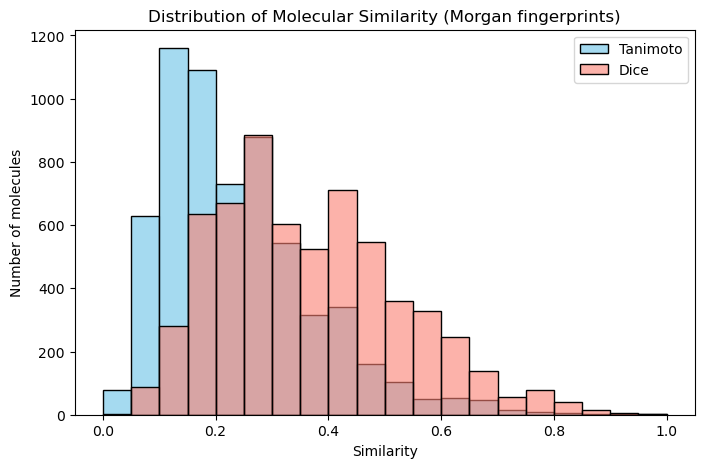

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(molecule_dataset["tanimoto_morgan"], bins=20, color='skyblue', label='Tanimoto')
sns.histplot(molecule_dataset["dice_morgan"], bins=20, color='salmon', label='Dice', alpha=0.6)
plt.xlabel("Similarity")
plt.ylabel("Number of molecules")
plt.title("Distribution of Molecular Similarity (Morgan fingerprints)")
plt.legend()
plt.show()

**Combination that retains the most similar molecules with the best inhibition activities**

We can plot a boxplot of the pIC50 values for the molecules selected by the four different screening methods to compare how they are distributed.

In [39]:
tanimoto_maccs_df = molecule_dataset[molecule_dataset['tanimoto_maccs'] > 0.5][['pIC50']].copy()
tanimoto_maccs_df['method'] = 'tanimoto_maccs'

dice_maccs_df = molecule_dataset[molecule_dataset['dice_maccs'] > 0.5][['pIC50']].copy()
dice_maccs_df['method'] = 'dice_maccs'

tanimoto_morgan_df = molecule_dataset[molecule_dataset['tanimoto_morgan'] > 0.5][['pIC50']].copy()
tanimoto_morgan_df['method'] = 'tanimoto_morgan'

dice_morgan_df = molecule_dataset[molecule_dataset['dice_morgan'] > 0.5][['pIC50']].copy()
dice_morgan_df['method'] = 'dice_morgan'

long_df = pd.concat([tanimoto_maccs_df, dice_maccs_df, tanimoto_morgan_df, dice_morgan_df], ignore_index=True)

print(long_df.head())
print(long_df['method'].value_counts())

      pIC50          method
0  5.484537  tanimoto_maccs
1  6.657577  tanimoto_maccs
2  6.677781  tanimoto_maccs
3  5.431798  tanimoto_maccs
4  6.040959  tanimoto_maccs
method
dice_maccs         5745
tanimoto_maccs     4005
dice_morgan        1233
tanimoto_morgan     274
Name: count, dtype: int64


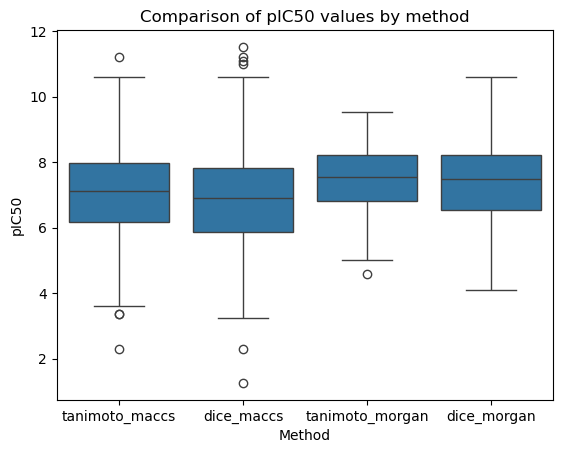

In [38]:
sns.boxplot(x='method', y='pIC50', data=long_df)
plt.title("Comparison of pIC50 values by method")
plt.ylabel("pIC50")
plt.xlabel("Method")
plt.show()

Although the Morgan + Tanimoto method produced the highest median pIC50 among the selected molecules, the Morgan + Dice combination offered the best balance between activity enrichment and dataset size, and was therefore chosen for QSAR modeling.

**Save the molecules retained by the best virtual screening combina4on in a CSV file (similarity
greater than 0.5)**

In [29]:
dice_morgan =  molecule_dataset[(molecule_dataset['dice_morgan']>0.5)  & (molecule_dataset['pIC50'].notna())]

In [30]:
dice_morgan.to_csv('C:/Users/Sossey/Documents/chemoinformatic/data/dice_morgan.csv')
molecule_dataset.to_csv('C:/Users/Sossey/Documents/chemoinformatic/data/molecule_dataset.csv')